In [2]:
import tensorflow as tf
import numpy as np
from pinn_neural_net import PINN_NeuralNet
from eikonal_pinn_solver import EikonalPINNSolver

In [3]:
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

N_0 = 50
N_b = 50
N_r = 10000

# Specify boundaries
lb = tf.constant([0., -1.], dtype=DTYPE)
ub = tf.constant([1., 1.], dtype=DTYPE)

def Eikonal_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Eikonal_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

In [4]:
tf.random.set_seed(0)

# Final time data
t_0 = tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Eikonal_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)
u_b = Eikonal_u_b(t_b, x_b)

# Collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

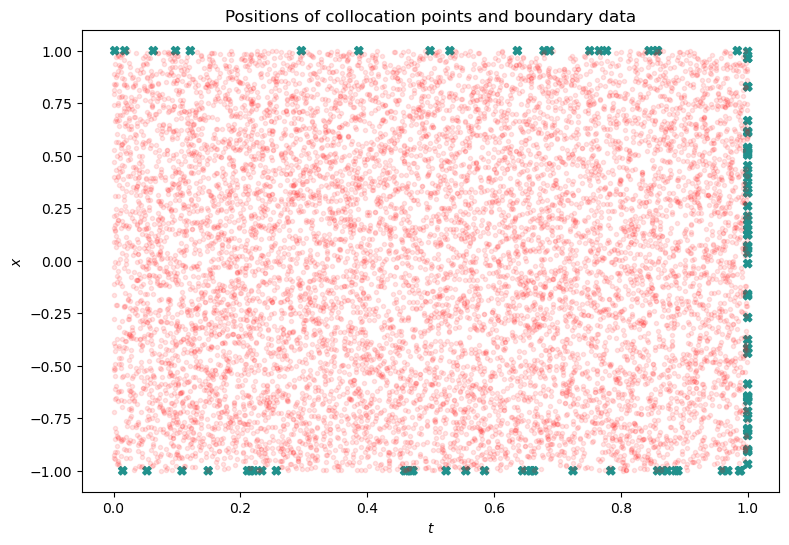

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [6]:
lambd_star = 3.

def u_expl(t, x, lambd_star):
    """Explicit solution of the parametric Eikonal equation."""
    y = 1./lambd_star
    return y * tf.math.minimum(1-t, 1-tf.abs(x))

In [7]:
N_d = 500
noise = 0.0

# Draw points with measurements randomly
t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
X_d = tf.concat([t_d, x_d], axis=1)
u_d = u_expl(t_d, x_d, lambd_star)
u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

# Copy original data
X_param = X_data
u_param = u_data

In [8]:
X_param.append(X_d)
u_param.append(u_d)

In [9]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)
        
        # Initialize variable for lambda
        self.lambd = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd_list = []

In [10]:
class EikonalPINNIdentification(EikonalPINNSolver):
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return -u_t + tf.abs(u_x) - 1./self.model.lambd
    
    def callback(self, xr=None):
        lambd = self.model.lambd.numpy()
        self.model.lambd_list.append(lambd)
        
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} lambda = {:10.8e}'.format(self.iter, self.current_loss, lambd))
        
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.plot(range(len(self.hist)), self.model.lambd_list,'-',color=color)
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color=color)
        return (ax1,ax2)

In [11]:
from time import time

# Initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2,
                                        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                        kernel_initializer='he_normal')

model.build(input_shape=(None,2))

# Initilize solver
eikonalIdentification = EikonalPINNIdentification(model, X_r)

# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
eikonalIdentification.solve_with_TFoptimizer(optim, X_param, u_param, N=10001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.41643448e+01 lambda = 1.09999990e+00
It 00050: loss = 5.10358326e-02 lambda = 1.90316045e+00
It 00100: loss = 1.54042654e-02 lambda = 2.06321573e+00
It 00150: loss = 1.13774622e-02 lambda = 2.15149999e+00
It 00200: loss = 1.04272366e-02 lambda = 2.22619510e+00
It 00250: loss = 6.94104703e-03 lambda = 2.30042505e+00
It 00300: loss = 4.53222729e-03 lambda = 2.35891056e+00
It 00350: loss = 3.47458688e-03 lambda = 2.40714431e+00
It 00400: loss = 2.05266871e-03 lambda = 2.44685602e+00
It 00450: loss = 1.51183177e-03 lambda = 2.48116779e+00
It 00500: loss = 1.14515238e-03 lambda = 2.51278901e+00
It 00550: loss = 1.01075997e-03 lambda = 2.54133725e+00
It 00600: loss = 8.93332879e-04 lambda = 2.56804633e+00
It 00650: loss = 8.38900276e-04 lambda = 2.59436655e+00
It 00700: loss = 6.78444689e-04 lambda = 2.62127590e+00
It 00750: loss = 5.82407403e-04 lambda = 2.64698148e+00
It 00800: loss = 4.63923498e-04 lambda = 2.67143798e+00
It 00850: loss = 3.74864147e-04 lambda = 2.69446

It 07350: loss = 8.45659898e-08 lambda = 2.99952173e+00
It 07400: loss = 8.42897592e-08 lambda = 2.99952173e+00
It 07450: loss = 8.40057126e-08 lambda = 2.99952173e+00
It 07500: loss = 8.37214529e-08 lambda = 2.99952173e+00
It 07550: loss = 8.34272527e-08 lambda = 2.99952173e+00
It 07600: loss = 8.30093114e-08 lambda = 2.99952173e+00
It 07650: loss = 8.27086097e-08 lambda = 2.99952173e+00
It 07700: loss = 8.24049806e-08 lambda = 2.99952173e+00
It 07750: loss = 8.20900468e-08 lambda = 2.99952173e+00
It 07800: loss = 8.17696915e-08 lambda = 2.99952173e+00
It 07850: loss = 8.14188681e-08 lambda = 2.99952173e+00
It 07900: loss = 8.10862986e-08 lambda = 2.99952173e+00
It 07950: loss = 8.07508158e-08 lambda = 2.99952173e+00
It 08000: loss = 8.02785109e-08 lambda = 2.99952173e+00
It 08050: loss = 7.96939190e-08 lambda = 2.99952173e+00
It 08100: loss = 7.93383492e-08 lambda = 2.99952173e+00
It 08150: loss = 7.89799941e-08 lambda = 2.99952173e+00
It 08200: loss = 7.86134748e-08 lambda = 2.99952

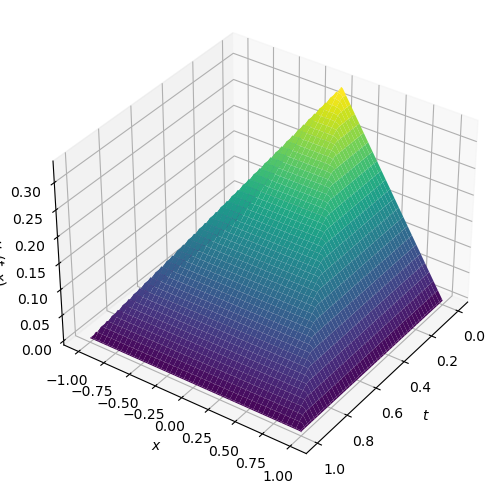

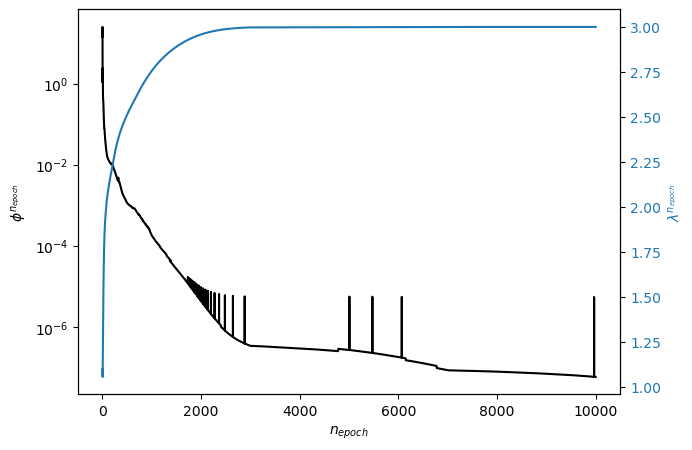

In [12]:
ax = eikonalIdentification.plot_solution()
#plt.savefig('Eikonal_PI_Solution.pdf', bbox_inches='tight', dpi=300)
axs = eikonalIdentification.plot_loss_and_param()
#plt.savefig('Eikonal_PI_LossEvolution.pdf', bbox_inches='tight', dpi=300)

In [13]:
lambd_rel_error = np.abs((eikonalIdentification.model.lambd.numpy()-lambd_star)/lambd_star)
print('Relative error of lambda ', lambd_rel_error)

Relative error of lambda  0.00013168652852376303


In [14]:
lambd_hist = []
loss_hist = []
for i in range(5):
    print('{:s}\nStart of iteration {:d}\n{:s}'.format(50*'-',i,50*'-'))
    # Initialize model
    model = PINNIdentificationNet(lb, ub, num_hidden_layers=2,
                                        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                        kernel_initializer='he_normal')

    model.build(input_shape=(None,2))

    # Initilize solver
    eikonalIdentification = EikonalPINNIdentification(model, X_r)

    # Choose step sizes aka learning rate
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])
    N=10001
    
    # Solve with Adam optimizer
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    eikonalIdentification.solve_with_TFoptimizer(optim, X_param, u_param, N=N)
    
    # Store evolution of lambdas
    lambd_hist.append(model.lambd_list)
    
    # Store evolution of losses
    loss_hist.append(eikonalIdentification.hist)

--------------------------------------------------
Start of iteration 0
--------------------------------------------------
It 00000: loss = 1.05365171e+01 lambda = 1.09999990e+00
It 00050: loss = 2.59514116e-02 lambda = 1.76901507e+00
It 00100: loss = 9.38040111e-03 lambda = 1.89685690e+00
It 00150: loss = 6.28328510e-03 lambda = 1.98469067e+00
It 00200: loss = 3.86072323e-03 lambda = 2.06171060e+00
It 00250: loss = 2.42269947e-03 lambda = 2.12763071e+00
It 00300: loss = 1.72219798e-03 lambda = 2.18416643e+00
It 00350: loss = 1.31970830e-03 lambda = 2.23461914e+00
It 00400: loss = 1.11024152e-03 lambda = 2.27964592e+00
It 00450: loss = 9.91695793e-04 lambda = 2.32096434e+00
It 00500: loss = 8.95361183e-04 lambda = 2.36114740e+00
It 00550: loss = 8.23586597e-04 lambda = 2.40076661e+00
It 00600: loss = 7.04937323e-04 lambda = 2.43873024e+00
It 00650: loss = 6.06872956e-04 lambda = 2.47510958e+00
It 00700: loss = 5.28553152e-04 lambda = 2.51034427e+00
It 00750: loss = 4.56023990e-04 lambd

It 07250: loss = 4.08050397e-07 lambda = 2.99474406e+00
It 07300: loss = 4.06300131e-07 lambda = 2.99475598e+00
It 07350: loss = 3.92622769e-06 lambda = 2.99477196e+00
It 07400: loss = 3.87641649e-06 lambda = 2.99478483e+00
It 07450: loss = 3.82855069e-06 lambda = 2.99479675e+00
It 07500: loss = 3.78340633e-06 lambda = 2.99480867e+00
It 07550: loss = 3.73784133e-06 lambda = 2.99482059e+00
It 07600: loss = 3.95421580e-07 lambda = 2.99482894e+00
It 07650: loss = 3.89337686e-07 lambda = 2.99484038e+00
It 07700: loss = 3.86276042e-07 lambda = 2.99485230e+00
It 07750: loss = 3.83858861e-07 lambda = 2.99486423e+00
It 07800: loss = 3.81630485e-07 lambda = 2.99487615e+00
It 07850: loss = 3.79858193e-07 lambda = 2.99488807e+00
It 07900: loss = 3.78042245e-07 lambda = 2.99489999e+00
It 07950: loss = 3.76069153e-07 lambda = 2.99491191e+00
It 08000: loss = 3.66845029e-06 lambda = 2.99493051e+00
It 08050: loss = 3.60738795e-06 lambda = 2.99495435e+00
It 08100: loss = 3.55008797e-06 lambda = 2.99497

It 04450: loss = 7.31025784e-06 lambda = 3.00037980e+00
It 04500: loss = 3.70199416e-07 lambda = 3.00032163e+00
It 04550: loss = 3.49832135e-07 lambda = 3.00023818e+00
It 04600: loss = 3.39423025e-07 lambda = 3.00015974e+00
It 04650: loss = 2.72995038e-07 lambda = 3.00008821e+00
It 04700: loss = 2.67465822e-07 lambda = 3.00001812e+00
It 04750: loss = 2.62671847e-07 lambda = 2.99995852e+00
It 04800: loss = 2.58713726e-07 lambda = 2.99989891e+00
It 04850: loss = 2.54583711e-07 lambda = 2.99985123e+00
It 04900: loss = 2.49724934e-07 lambda = 2.99980450e+00
It 04950: loss = 2.45369563e-07 lambda = 2.99976873e+00
It 05000: loss = 2.42060082e-07 lambda = 2.99973297e+00
It 05050: loss = 2.38329193e-07 lambda = 2.99970174e+00
It 05100: loss = 2.34482982e-07 lambda = 2.99967551e+00
It 05150: loss = 2.30211356e-07 lambda = 2.99965167e+00
It 05200: loss = 2.26577953e-07 lambda = 2.99962783e+00
It 05250: loss = 2.22449160e-07 lambda = 2.99960637e+00
It 05300: loss = 2.18771149e-07 lambda = 2.99959

It 01650: loss = 4.94634114e-05 lambda = 2.99864244e+00
It 01700: loss = 5.03514711e-05 lambda = 2.99727535e+00
It 01750: loss = 3.67302528e-05 lambda = 2.99581361e+00
It 01800: loss = 2.73109708e-05 lambda = 2.99494338e+00
It 01850: loss = 2.21081955e-05 lambda = 2.99453783e+00
It 01900: loss = 1.80300049e-05 lambda = 2.99477506e+00
It 01950: loss = 1.61872376e-05 lambda = 2.99499345e+00
It 02000: loss = 1.43620746e-05 lambda = 2.99535561e+00
It 02050: loss = 1.37879260e-05 lambda = 2.99582863e+00
It 02100: loss = 1.37607985e-05 lambda = 2.99615884e+00
It 02150: loss = 1.70524509e-05 lambda = 2.99544001e+00
It 02200: loss = 2.07703324e-05 lambda = 2.99552703e+00
It 02250: loss = 2.65894487e-04 lambda = 2.99564314e+00
It 02300: loss = 1.12015605e-05 lambda = 2.99775243e+00
It 02350: loss = 1.94056465e-05 lambda = 2.99760842e+00
It 02400: loss = 4.14612950e-05 lambda = 2.99780202e+00
It 02450: loss = 1.27442290e-05 lambda = 2.99750233e+00
It 02500: loss = 6.62165869e-04 lambda = 2.99645

It 09000: loss = 1.22372512e-06 lambda = 2.99845529e+00
It 09050: loss = 1.22062909e-06 lambda = 2.99846649e+00
It 09100: loss = 1.20858715e-06 lambda = 2.99847794e+00
It 09150: loss = 1.20719426e-06 lambda = 2.99848938e+00
It 09200: loss = 1.16008255e-06 lambda = 2.99849963e+00
It 09250: loss = 1.12821181e-06 lambda = 2.99850845e+00
It 09300: loss = 1.14336615e-06 lambda = 2.99851823e+00
It 09350: loss = 1.13477324e-06 lambda = 2.99852562e+00
It 09400: loss = 1.12766566e-06 lambda = 2.99852991e+00
It 09450: loss = 1.15607327e-06 lambda = 2.99853683e+00
It 09500: loss = 1.12581449e-06 lambda = 2.99854612e+00
It 09550: loss = 1.07636549e-06 lambda = 2.99855781e+00
It 09600: loss = 1.06934158e-06 lambda = 2.99856496e+00
It 09650: loss = 1.12037026e-06 lambda = 2.99857140e+00
It 09700: loss = 1.11099757e-06 lambda = 2.99857664e+00
It 09750: loss = 1.05859647e-06 lambda = 2.99858713e+00
It 09800: loss = 1.06246489e-06 lambda = 2.99860024e+00
It 09850: loss = 1.05474169e-06 lambda = 2.99861

It 06200: loss = 1.58722159e-07 lambda = 2.99618554e+00
It 06250: loss = 1.53188367e-07 lambda = 2.99630475e+00
It 06300: loss = 1.47924126e-07 lambda = 2.99642396e+00
It 06350: loss = 1.42944785e-07 lambda = 2.99654317e+00
It 06400: loss = 1.38136599e-07 lambda = 2.99666238e+00
It 06450: loss = 1.33063793e-07 lambda = 2.99678159e+00
It 06500: loss = 1.27945441e-07 lambda = 2.99690080e+00
It 06550: loss = 1.23757331e-07 lambda = 2.99702001e+00
It 06600: loss = 1.19671725e-07 lambda = 2.99713922e+00
It 06650: loss = 1.15917651e-07 lambda = 2.99725819e+00
It 06700: loss = 8.44250181e-08 lambda = 2.99737000e+00
It 06750: loss = 5.13624165e-08 lambda = 2.99748445e+00
It 06800: loss = 4.83403682e-08 lambda = 2.99759412e+00
It 06850: loss = 4.55207925e-08 lambda = 2.99770141e+00
It 06900: loss = 4.18911732e-08 lambda = 2.99780869e+00
It 06950: loss = 3.90563457e-08 lambda = 2.99791598e+00
It 07000: loss = 3.63763704e-08 lambda = 2.99802327e+00
It 07050: loss = 3.60773136e-08 lambda = 2.99803

It 03400: loss = 3.30768512e-06 lambda = 2.99932885e+00
It 03450: loss = 2.91491278e-06 lambda = 2.99928117e+00
It 03500: loss = 2.70890587e-06 lambda = 2.99923348e+00
It 03550: loss = 2.65253470e-06 lambda = 2.99918413e+00
It 03600: loss = 2.51077813e-06 lambda = 2.99913645e+00
It 03650: loss = 2.17395882e-06 lambda = 2.99908876e+00
It 03700: loss = 2.24815699e-06 lambda = 2.99904108e+00
It 03750: loss = 2.11908059e-06 lambda = 2.99899340e+00
It 03800: loss = 2.11792644e-06 lambda = 2.99894571e+00
It 03850: loss = 2.07682638e-06 lambda = 2.99889803e+00
It 03900: loss = 2.04994330e-06 lambda = 2.99885035e+00
It 03950: loss = 2.01863736e-06 lambda = 2.99880266e+00
It 04000: loss = 1.98934345e-06 lambda = 2.99875498e+00
It 04050: loss = 1.96850442e-06 lambda = 2.99871278e+00
It 04100: loss = 1.93439200e-06 lambda = 2.99867702e+00
It 04150: loss = 1.90655078e-06 lambda = 2.99864054e+00
It 04200: loss = 1.75654657e-06 lambda = 2.99860382e+00
It 04250: loss = 1.71674526e-06 lambda = 2.99855

In [15]:
print('  i     Mean of lambda   Std. of lambda')
for i in [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]:
    xi = np.array([ x[i] for x in lambd_hist])
    print('{:05d}     {:6.4e}       {:6.4e}'.format(i, xi.mean(), xi.std()))

  i     Mean of lambda   Std. of lambda
01000     2.8566e+00       1.0153e-01
02000     2.9834e+00       2.3992e-02
03000     2.9936e+00       6.9637e-03
04000     2.9947e+00       5.2265e-03
05000     2.9959e+00       3.4087e-03
06000     2.9970e+00       2.2932e-03
07000     2.9980e+00       1.7833e-03
08000     2.9981e+00       1.7098e-03
09000     2.9984e+00       1.5987e-03
10000     2.9986e+00       1.4303e-03


(2.8, 3.2)

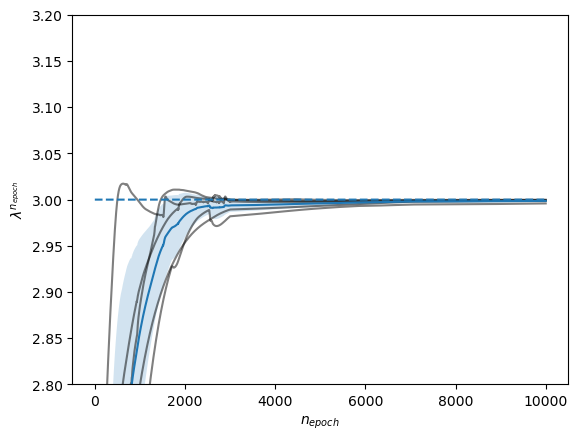

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = 'tab:blue'

Lambd = np.stack(lambd_hist)
lmean = Lambd.mean(axis=0)
lstd = Lambd.std(axis=0)
Lambd_RelError = np.abs((Lambd-lambd_star)/lambd_star)
lrange=range(len(lmean))

for i in range(len(lambd_hist)):
    ax.plot(lrange, lambd_hist[i],'-',color='black', alpha=0.5)
ax.plot(lrange, lmean,'-',color=color)
ax.plot(lrange, lambd_star*np.ones_like(lmean),'--',color=color)
ax.fill_between(lrange,lmean-lstd,lmean+lstd, alpha=0.2)
ax.set_ylabel('$\\lambda^{n_{epoch}}$')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylim([2.8,3.2])
#plt.savefig('Eikonal_PI_Evolution.pdf', bbox_inches='tight', dpi=300)

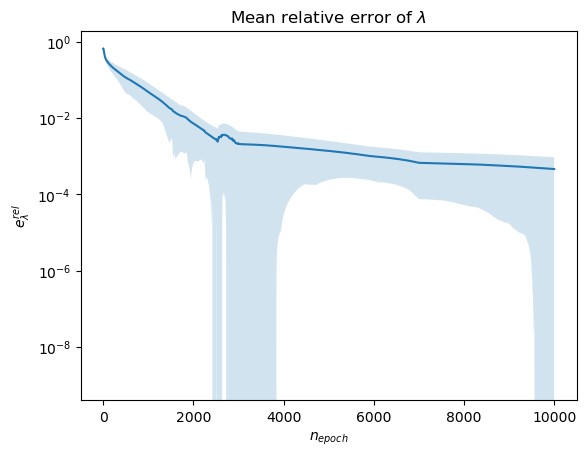

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(lrange,Lambd_RelError.mean(axis=0))
ax.fill_between(lrange,Lambd_RelError.mean(axis=0)-Lambd_RelError.std(axis=0),
                Lambd_RelError.mean(axis=0)+Lambd_RelError.std(axis=0), alpha=0.2)
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$e_{\\lambda}^{rel}$')
ax.set_title('Mean relative error of $\\lambda$');